In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from catboost import CatBoostClassifier

In [16]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

def print_classification_report(y_true, y_pred, model_name):
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Miss", "Make"]))

def plot_feature_importances(model, feature_names, model_name):
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(11, 8))
    plt.barh(np.array(feature_names)[sorted_idx][:11], feature_importances[sorted_idx][:11], align="center")
    plt.xlabel("Feature Importance")
    plt.title(f"{model_name} Feature Importances (Top 10)")
    plt.gca().invert_yaxis()
    plt.show()

In [10]:
# Load data
clustering_data = pd.read_csv('Clustering.csv')
pbp_data = pd.read_csv('Regular Season PbP.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

clustering_data = clustering_data[['Year', 'Player', 'Pos', 'cluster']]
merged_data = pbp_data.merge(
    clustering_data,
    how='left',
    on=['Year', 'Player']
)

In [11]:
# Drop specified columns and rows with empty values
data = merged_data.drop(columns=['Year', 'Opponent', 'Team', 'Player ID', 'Game ID', 'cluster', 'Player']).dropna()

# Encode categorical variables
data["Result"] = data["Result"].replace({"Make": True, "Miss": False})
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data["Pos_C"] = ~(data[["Pos_PG", "Pos_SG", "Pos_PF", "Pos_SF"]].any(axis=1))

# Scale numerical features
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Split data into features and target
X = data.drop(columns=['Result'])
y = data['Result']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of data: {data.shape}")

C:\Users\nadee_4wl0sna\AppData\Local\Temp\ipykernel_8968\3829675102.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Result"] = data["Result"].replace({"Make": True, "Miss": False})


Shape of data: (2140691, 12)


In [12]:
# Train CatBoost model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Predictions
y_pred = catboost_model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy: {accuracy:.4f}")

CatBoost Accuracy: 0.6127


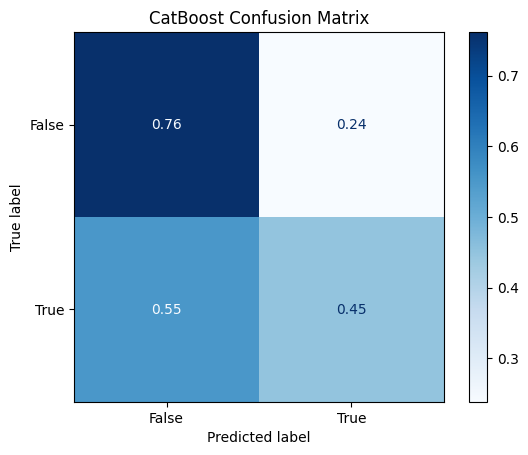

CatBoost Classification Report:
              precision    recall  f1-score   support

        Miss       0.61      0.76      0.67    225560
        Make       0.63      0.45      0.52    202579

    accuracy                           0.61    428139
   macro avg       0.62      0.60      0.60    428139
weighted avg       0.62      0.61      0.60    428139



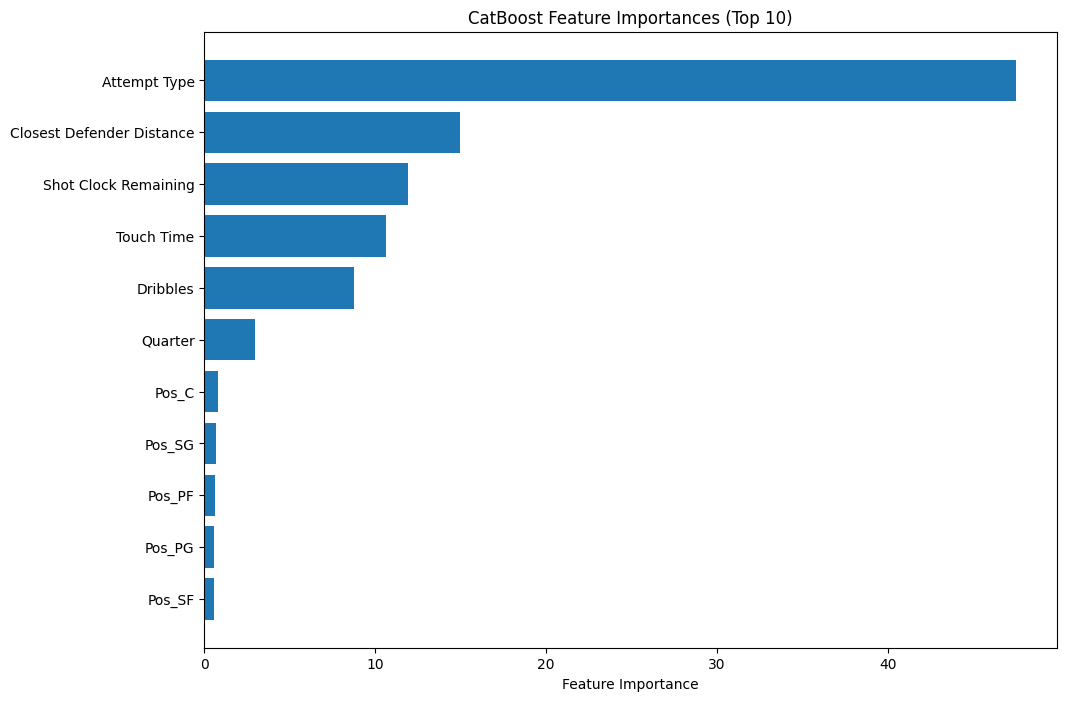

In [17]:
# Plots
plot_confusion_matrix(y_test, y_pred, "CatBoost")
print_classification_report(y_test, y_pred, "CatBoost")
plot_feature_importances(catboost_model, X_train.columns, "CatBoost")